In [1]:
#!pip install scikit-learn meteostat geopy matplotlib seaborn

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
#!pip install mlflow

In [4]:
import os, time, pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from meteostat import Point, Daily
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import mlflow
import mlflow.pytorch

In [5]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Weather-LSTM-Experiment")
mlflow.pytorch.autolog()

HIDDEN_SIZE = 16
NUM_LAYERS = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 1024
N_STEPS = 7
EARLY_STOPPING_PATIENCE = 20

TARGET_CITY = "Budapest"
MAX_RADIUS_KM = 2000
ONLY_CAPITALS = True
RELOAD_CITIES = False

CACHE_VERIFIED = "../data/raw/verified_coordinates.pkl"
CACHE_FAILED = "../data/raw/unresolvable_cities.pkl"
log_file = "../data/processed/training_log.csv"
TARGET_COLUMN = "Budapest_tmax"
MODEL_DIR = "../models"

2025/05/30 04:28:26 INFO mlflow.tracking.fluent: Experiment with name 'Weather-LSTM-Experiment' does not exist. Creating a new experiment.


In [6]:
def load_and_filter_cities():
    df = pd.read_csv("../data/raw/worldcities.csv")
    target = df[df["city_ascii"] == TARGET_CITY]
    if target.empty:
        raise ValueError(f"A megadott célváros ({TARGET_CITY}) nem található az adatbázisban.")

    if ONLY_CAPITALS:
        df = df[df["capital"] == "primary"]

    df = df[df.apply(lambda row: geodesic((target.iloc[0]["lat"], target.iloc[0]["lng"]), (row["lat"], row["lng"])).km <= MAX_RADIUS_KM, axis=1)]

    if TARGET_CITY not in df["city_ascii"].values:
        df = pd.concat([df, target])

    return {row["city_ascii"]: (row["lat"], row["lng"]) for _, row in df.iterrows()}

city_coordinates = load_and_filter_cities()
print(f"{len(city_coordinates)} város kiválasztva {MAX_RADIUS_KM} km-en belül {TARGET_CITY} körül.")
print(" ->", ", ".join(sorted(city_coordinates.keys())))

52 város kiválasztva 2000 km-en belül Budapest körül.
 -> Algiers, Amsterdam, Andorra la Vella, Ankara, Athens, Belgrade, Berlin, Bern, Bratislava, Brussels, Bucharest, Budapest, Chisinau, Copenhagen, Douglas, Dublin, Helsinki, Kyiv, Ljubljana, London, Luxembourg, Madrid, Minsk, Monaco, Moscow, Nicosia, Oslo, Paris, Podgorica, Prague, Pristina, Riga, Rome, Saint Helier, Saint Peter Port, San Marino, Sarajevo, Skopje, Sofia, Stockholm, Tallinn, The Hague, Tirana, Tripoli, Tunis, Vaduz, Valletta, Vatican City, Vienna, Vilnius, Warsaw, Zagreb


In [7]:
def load_pickle_file(path, default):
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return default


def save_pickle_file(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)


def initialize_geolocator():
    return Nominatim(user_agent="weather_project")

In [8]:
def query_city_coordinates(geolocator, city_list, verified, unresolvable, reload=False):
    for city in city_list:
        if city in verified:
            continue
        if not reload and city in unresolvable:
            print(f"{city}: korábban nem található, most sem próbáljuk újra.")
            continue
        try:
            location = geolocator.geocode(f"{city}, Europe")
            if location:
                coords = (location.latitude, location.longitude)
                verified[city] = coords
                print(f"{city}: ({coords[0]:.4f}, {coords[1]:.4f})")
            else:
                print(f"{city}: Nem található.")
                unresolvable.add(city)
        except Exception as e:
            print(f"Hiba {city} lekérdezésekor: {e}")
            unresolvable.add(city)
        time.sleep(1)
    return verified, unresolvable

In [9]:
verified_coordinates = load_pickle_file(CACHE_VERIFIED, {})
if verified_coordinates:
    print(f"{len(verified_coordinates)} város koordinátája már korábban letöltve.")

unresolvable_cities = load_pickle_file(CACHE_FAILED, set()) if not RELOAD_CITIES else set()

geolocator = initialize_geolocator()
verified_coordinates, unresolvable_cities = query_city_coordinates(
    geolocator,
    city_coordinates.keys(),
    verified_coordinates,
    unresolvable_cities,
    reload=RELOAD_CITIES
)

save_pickle_file(CACHE_VERIFIED, verified_coordinates)
save_pickle_file(CACHE_FAILED, unresolvable_cities)

city_coordinates = verified_coordinates

22 város koordinátája már korábban letöltve.
Ankara: korábban nem található, most sem próbáljuk újra.
Algiers: korábban nem található, most sem próbáljuk újra.
Vienna: korábban nem található, most sem próbáljuk újra.
Warsaw: korábban nem található, most sem próbáljuk újra.
Minsk: korábban nem található, most sem próbáljuk újra.
Copenhagen: korábban nem található, most sem próbáljuk újra.
Helsinki: korábban nem található, most sem próbáljuk újra.
Belgrade: korábban nem található, most sem próbáljuk újra.
Tripoli: korábban nem található, most sem próbáljuk újra.
Zagreb: korábban nem található, most sem próbáljuk újra.
Oslo: korábban nem található, most sem próbáljuk újra.
Chisinau: korábban nem található, most sem próbáljuk újra.
Tallinn: korábban nem található, most sem próbáljuk újra.
Riga: korábban nem található, most sem próbáljuk újra.
Tunis: korábban nem található, most sem próbáljuk újra.
Vilnius: korábban nem található, most sem próbáljuk újra.
The Hague: korábban nem található, 

In [10]:
def ensure_data_directory(path="data"):
    os.makedirs(path, exist_ok=True)

def load_existing_weather_data(file_path, start, end):
    if not os.path.exists(file_path):
        return None, False

    try:
        data = pd.read_csv(file_path, parse_dates=["time"], index_col="time")
        if not data.empty:
            min_date, max_date = data.index.min(), data.index.max()
            if min_date <= start and max_date >= end:
                print(f"{os.path.basename(file_path)}: meglévő adat teljes időtartományban.")
                return data, True
            else:
                print(f"{os.path.basename(file_path)}: adat hiányos ({min_date.date()} – {max_date.date()}).")
    except Exception as e:
        print(f"{os.path.basename(file_path)}: hiba a fájl beolvasásakor – új letöltés szükséges. ({e})")

    return None, False

def download_weather_data(name, lat, lon, start, end, file_path):
    try:
        point = Point(lat, lon)
        data = Daily(point, start, end).fetch()
        data = data[["tavg", "tmin", "tmax", "prcp", "wspd"]]
        data.to_csv(file_path)
        print(f"{name}: adat letöltve és mentve.")
        return data
    except Exception as e:
        print(f"{name} adatainak lekérése sikertelen: {e}")
        return None

def validate_time_range(data, start, end, name):
    if data is None or data.empty:
        return False
    if data.index.min() > start or data.index.max() < end:
        print(f"{name}: kihagyva, mert nem teljes az időtartomány "
              f"({data.index.min().date()} – {data.index.max().date()})")
        return False
    return True


In [11]:
start = datetime(2000, 1, 1)
end = datetime(2024, 12, 31)

ensure_data_directory("../data/raw")
all_data = {}

for name, (lat, lon) in city_coordinates.items():
    file_path = f"../data/raw/{name}.csv"

    data, valid = load_existing_weather_data(file_path, start, end)

    # Ha nincs érvényes adat, töltsük le
    if not valid:
        data = download_weather_data(name, lat, lon, start, end, file_path)

    if not validate_time_range(data, start, end, name):
        continue

    data.columns = [f"{name}_{col}" for col in data.columns]
    all_data[name] = data

df = pd.concat(all_data.values(), axis=1, join="inner")
df.reset_index(inplace=True)
df.to_csv("../data/processed/european_capitals_weather_combined.csv", index=False)

df.head()

Moscow.csv: meglévő adat teljes időtartományban.
London.csv: meglévő adat teljes időtartományban.
Paris.csv: meglévő adat teljes időtartományban.
Madrid.csv: meglévő adat teljes időtartományban.
Berlin.csv: meglévő adat teljes időtartományban.
Athens.csv: meglévő adat teljes időtartományban.
Kyiv.csv: meglévő adat teljes időtartományban.
Rome.csv: meglévő adat teljes időtartományban.
Bucharest.csv: meglévő adat teljes időtartományban.
Budapest.csv: meglévő adat teljes időtartományban.
Amsterdam.csv: meglévő adat teljes időtartományban.
Sofia.csv: meglévő adat teljes időtartományban.
Prague.csv: meglévő adat teljes időtartományban.
Brussels.csv: meglévő adat teljes időtartományban.
Stockholm.csv: meglévő adat teljes időtartományban.
Dublin.csv: meglévő adat teljes időtartományban.
Skopje.csv: meglévő adat teljes időtartományban.
Tirana.csv: adat hiányos (2000-01-02 – 2024-12-31).
Tirana adatainak lekérése sikertelen: No module named 'numpy._core'
Sarajevo.csv: meglévő adat teljes időtar

,time,Moscow_tavg,Moscow_tmin,Moscow_tmax,Moscow_prcp,Moscow_wspd,London_tavg,London_tmin,London_tmax,London_prcp,...,Sarajevo_tavg,Sarajevo_tmin,Sarajevo_tmax,Sarajevo_prcp,Sarajevo_wspd,Luxembourg_tavg,Luxembourg_tmin,Luxembourg_tmax,Luxembourg_prcp,Luxembourg_wspd
0,2000-01-01,-4.4,-4.9,-3.6,1.5,NaN,9.5,8.9,10.3,1.8,...,9.8,8.6,11.0,NaN,11.4,8.2,7.2,9.8,0.5,6.7
1,2000-01-02,-7.7,-9.0,-7.0,0.3,NaN,9.5,8.0,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,8.2,6.6,9.2,0.0,7.4
2,2000-01-03,-9.3,-11.0,-9.0,0.2,NaN,9.4,5.6,11.2,2.0,...,NaN,NaN,NaN,NaN,NaN,7.8,6.6,9.6,1.5,11.4
3,2000-01-04,-6.1,-9.1,-2.3,2.5,NaN,6.3,5.0,9.4,3.8,...,10.7,6.6,12.5,NaN,21.3,8.4,6.4,10.8,0.0,19.1
4,2000-01-05,0.1,-2.4,1.4,2.5,NaN,8.1,4.6,11.1,NaN,...,NaN,NaN,NaN,NaN,NaN,7.6,5.9,10.8,4.3,12.5


In [12]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
raw_features = df.drop(columns=["time"])

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(raw_features), columns=raw_features.columns)

cleaned_features = scaled_features.dropna(axis=1)

features = cleaned_features.values

print("Maradt oszlop:", features.shape[1])

target_series = df[TARGET_COLUMN].values[N_STEPS:]

if TARGET_COLUMN not in df.columns:
    raise ValueError(f"A megadott célváltozó ({TARGET_COLUMN}) nem található a DataFrame-ben!")

target_series = df[TARGET_COLUMN].values


X = []
y = []

for i in range(N_STEPS, len(features)):
    X.append(features[i - N_STEPS:i])
    y.append(target_series[i])

X = np.array(X)
y = np.array(y)

# Belefutottunk NaN értékekbe tanulítás során ezért megvizsgáljuk az adatokat
print("Y statisztika:")
print("\tY NaN:", np.isnan(y).any())
print("\tY Inf:", np.isinf(y).any())
print("\tY max:", np.max(y))
print("\tY min:", np.min(y))
print(f"\tSzórás: {np.std(y):.4f}")
print(f"\tÁtlag: {np.mean(y):.4f}")

print("X statisztika:")
print("\tX NaN:", np.isnan(X).any())
print("\tX Inf:", np.isinf(X).any())
print("\tX max:", np.max(X))
print("\tX min:", np.min(X))
print(f"\tSzórás: {np.std(X):.4f}")
print(f"\tÁtlag: {np.mean(X):.4f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Maradt oszlop: 48
Y statisztika:
	Y NaN: False
	Y Inf: False
	Y max: 42.6
	Y min: -5.1
	Szórás: 7.7506
	Átlag: 16.9958
X statisztika:
	X NaN: False
	X Inf: False
	X max: 22.919412775789798
	X min: -3.722916988155856
	Szórás: 1.0000
	Átlag: 0.0007


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [15]:
class EarlyStopping:
    def __init__(self, patience=EARLY_STOPPING_PATIENCE, verbose=True, delta=1e-4):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience} epoch óta nincs javulás.", end=' ')
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
print("CUDA elérhető:", torch.cuda.is_available())
print("CUDA verzió:", torch.version.cuda)
print("PyTorch build CUDA-támogatással:", torch.backends.cudnn.enabled)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Alapértelmezett eszköz:", device)

CUDA elérhető: True
CUDA verzió: 12.1
PyTorch build CUDA-támogatással: True
Alapértelmezett eszköz: cuda


In [17]:
model = LSTMModel(input_size=X.shape[2], hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
epoch = 0
train_loss_history = []
start_time = time.time()


while epoch < 10000:
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"\nEpoch {epoch+1}, Loss: {train_loss:.4f}", end=' ')
    train_loss_history.append(train_loss)


    early_stopping(train_loss)
    if early_stopping.early_stop:
        print("Korai leállítás aktiválva.")
        break

    epoch += 1

end_time = time.time()
elapsed_time = end_time - start_time


Epoch 1, Loss: 344.9498 
Epoch 2, Loss: 338.8456 
Epoch 3, Loss: 333.6086 
Epoch 4, Loss: 328.5410 
Epoch 5, Loss: 323.5023 
Epoch 6, Loss: 318.2903 
Epoch 7, Loss: 312.8982 
Epoch 8, Loss: 307.3539 
Epoch 9, Loss: 301.7803 
Epoch 10, Loss: 296.1423 
Epoch 11, Loss: 290.5159 
Epoch 12, Loss: 284.9633 
Epoch 13, Loss: 279.4878 
Epoch 14, Loss: 274.2010 
Epoch 15, Loss: 269.0927 
Epoch 16, Loss: 264.0571 
Epoch 17, Loss: 258.9294 
Epoch 18, Loss: 253.6625 
Epoch 19, Loss: 248.1286 
Epoch 20, Loss: 242.2289 
Epoch 21, Loss: 235.6041 
Epoch 22, Loss: 228.1496 
Epoch 23, Loss: 220.2097 
Epoch 24, Loss: 211.5967 
Epoch 25, Loss: 201.4247 
Epoch 26, Loss: 191.3541 
Epoch 27, Loss: 183.8790 
Epoch 28, Loss: 177.9992 
Epoch 29, Loss: 173.0050 
Epoch 30, Loss: 168.6691 
Epoch 31, Loss: 164.7784 
Epoch 32, Loss: 161.1707 
Epoch 33, Loss: 157.8038 
Epoch 34, Loss: 154.6011 
Epoch 35, Loss: 151.5540 
Epoch 36, Loss: 148.6138 
Epoch 37, Loss: 145.7650 
Epoch 38, Loss: 142.9866 
Epoch 39, Loss: 140.

In [19]:
fname_suffix = f"H{HIDDEN_SIZE}_L{NUM_LAYERS}_LR{LEARNING_RATE}_BS{BATCH_SIZE}_S{N_STEPS}_PAT{EARLY_STOPPING_PATIENCE}"

os.makedirs("../data/processed/logs", exist_ok=True)
os.makedirs("../data/processed/plots", exist_ok=True)

csv_path = os.path.join("../data/processed/logs", f"train_loss_{fname_suffix}.csv")
png_path = os.path.join("../data/processed/plots", f"train_loss_{fname_suffix}.png")

In [20]:
pd.DataFrame({
    "epoch": list(range(1, len(train_loss_history) + 1)),
    "train_loss": train_loss_history
}).to_csv(csv_path, index=False)

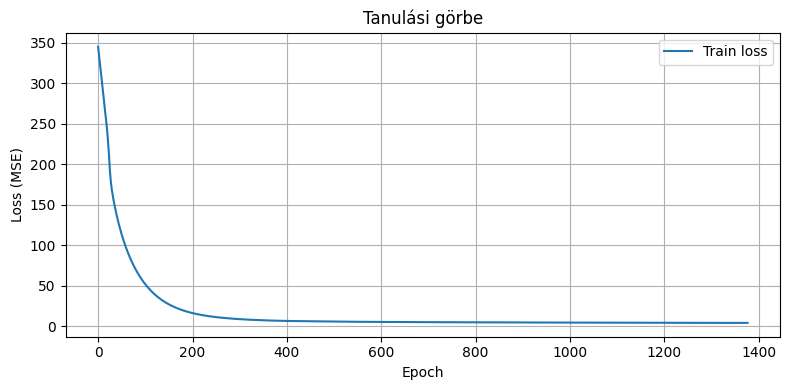

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Tanulási görbe")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(png_path)
plt.show()

In [22]:
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, f"model_{fname_suffix}.pt")
torch.save(model.state_dict(), model_path)

print(f"Modell mentve: {model_path}")

Modell mentve: ../models\model_H16_L1_LR0.001_BS1024_S7_PAT20.pt


In [23]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs.flatten())
        actuals.extend(targets.numpy().flatten())

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)

print(f"Teszt MSE: {mse:.3f}")
print(f"Teszt MAE: {mae:.3f}")

Teszt MSE: 7.694
Teszt MAE: 2.159


In [24]:

log_columns = [
    "training", "hidden_size", "learning_rate","layers", "epochs", "batch_size",
    "train_loss", "test_mse", "test_mae", "elapsed_time"
]

if not os.path.exists(log_file):
    pd.DataFrame(columns=log_columns).to_csv(log_file, index=False)

log_entry = {
    "training": csv_path,
    "hidden_size": HIDDEN_SIZE,
    "learning_rate": LEARNING_RATE,
    "layers" : NUM_LAYERS,
    "epochs" : epoch + 1,
    "batch_size": BATCH_SIZE,
    "train_loss": train_loss,
    "test_mse": mse,
    "test_mae": mae,
    "elapsed_time": round(elapsed_time, 2)
}

log_df = pd.read_csv(log_file)
log_df = pd.concat([log_df, pd.DataFrame([log_entry])], ignore_index=True)
log_df.to_csv(log_file, index=False)